<h1><center>  LSTM Forecasting of Beijing Air Pollution </center></h1>

In this notebook, we attempt a simple exploration of LSTM's for time-series predictions. I have been itching to have a go again at neural networks, having last learnt about this close to two years ago in Andrew Ng's coursera specialisation.

![Beijing Air Pollution](img/beijing.jpg)

<center> image source: https://handswideopen.wordpress.com/2013/02/01/the-air-up-there-china-edition/ </center>

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration
- DEWP: Dew Point
- TEMP: Temperature
- PRES: Pressure
- cbwd: Combined wind direction
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

Source: Mirror of UCI Machine Learning Repository hosted on https://machinelearningmastery.com/. <br>
Acknowledgement: 

- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ : Approach to LSTM and how to reshape to incorporate memory
- https://stackoverflow.com/questions/38714959/understanding-keras-lstms : Notes on how to visualise memory
- https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/ : Additional pointers for reshaping to store memory
- https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/: Guide to handle missing values
- http://jmlr.org/papers/v15/srivastava14a.html: paper on dropout regularisation
- http://philipperemy.github.io/keras-stateful-lstm/: article on statefulness of LSTM
- https://machinelearningmastery.com/stacked-long-short-term-memory-networks/: article on stacking LSTM networks

<h2>1) Load packages and data</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking #https://github.com/keras-team/keras/issues/12783#issuecomment-547853852
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans #https://predictivehacks.com/k-means-elbow-method-code-for-python/

my_random_seed = 42

In [2]:
df_loaded = pd.read_csv(r"DATA/pollution.csv")
this_memory = df_loaded.memory_usage().sum() / 1024**2
print("Memory usage of pollution.csv is {:.2f} MB\n".format(this_memory))

Memory usage of pollution.csv is 4.35 MB



In [3]:
df_raw = df_loaded.copy()
df_raw.drop('No',axis=1,inplace=True)
df_raw.columns = ['year','month','day','hour','PM25_CONCENTRATION_THIS_HOUR','DEW_POINT','TEMPERATURE','PRESSURE','WIND_DIRECTION','WIND_SPEED','SNOW_HOURS_CUMULATIVE','RAIN_HOURS_CUMULATIVE']
df_raw.head(30)

,year,month,day,hour,PM25_CONCENTRATION_THIS_HOUR,DEW_POINT,TEMPERATURE,PRESSURE,WIND_DIRECTION,WIND_SPEED,SNOW_HOURS_CUMULATIVE,RAIN_HOURS_CUMULATIVE
0,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


<h2>2) EDA</h2>

### > Check for duplicates

In [4]:
df_raw[df_raw.duplicated()]

,year,month,day,hour,PM25_CONCENTRATION_THIS_HOUR,DEW_POINT,TEMPERATURE,PRESSURE,WIND_DIRECTION,WIND_SPEED,SNOW_HOURS_CUMULATIVE,RAIN_HOURS_CUMULATIVE


No duplicates.

### > Create datetime and use as index

We will shift based on date and time. Therefore, datetime needs to be the index.

In [5]:
df_raw['DATETIME'] = pd.to_datetime(df_raw[['year','month','day','hour']])
df_raw = df_raw.set_index('DATETIME')
df_raw = df_raw.sort_index()
# remove year, month, day and hour
df_raw.drop(['year','month','day','hour'],axis=1,inplace=True)
df_raw.head(60)

,PM25_CONCENTRATION_THIS_HOUR,DEW_POINT,TEMPERATURE,PRESSURE,WIND_DIRECTION,WIND_SPEED,SNOW_HOURS_CUMULATIVE,RAIN_HOURS_CUMULATIVE
DATETIME,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,NaN,-19,-9.0,1017.0,NW,24.15,0,0


### > Check that hourly data is available for all dates included in data.

In [6]:
# add 1 to datediff to inlude starting date

len(df_raw) == (((df_raw.index.max()-df_raw.index.min()).days + 1) * 24) 

True

Given that we do not have duplicates, and that the number of rows is equal to the number of hours from the start date to end date, we can confirm that hourly data is fully available.

### > Missing values

In [7]:
df_raw.isnull().sum()

PM25_CONCENTRATION_THIS_HOUR    2067
DEW_POINT                          0
TEMPERATURE                        0
PRESSURE                           0
WIND_DIRECTION                     0
WIND_SPEED                         0
SNOW_HOURS_CUMULATIVE              0
RAIN_HOURS_CUMULATIVE              0
dtype: int64

In [8]:
df_raw.shape

(43824, 8)

2000 rows with missing target values out of 43824 is less than 5%.

### > Data distributions and correlations

In [9]:
df_raw.describe()

,PM25_CONCENTRATION_THIS_HOUR,DEW_POINT,TEMPERATURE,PRESSURE,WIND_SPEED,SNOW_HOURS_CUMULATIVE,RAIN_HOURS_CUMULATIVE
count,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


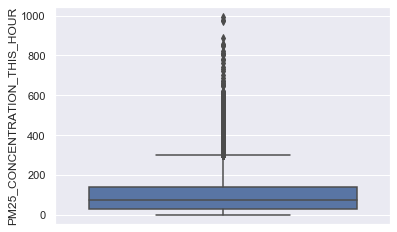

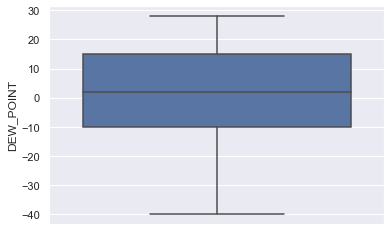

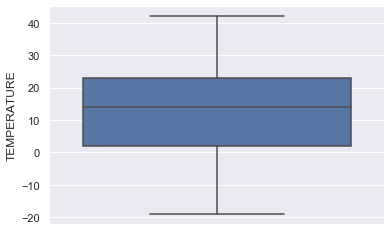

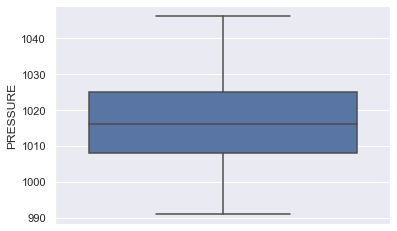

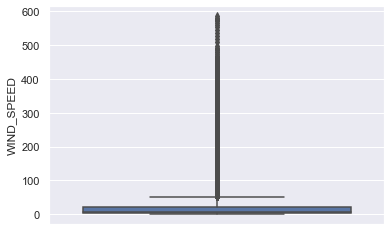

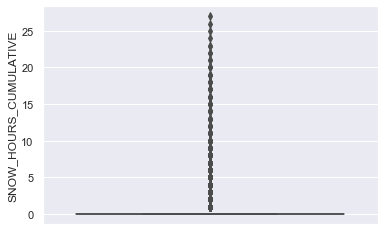

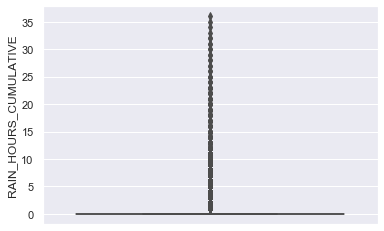

In [10]:
# use seaborn to preserve memory. Standard matplotlib.pyplot consumes alot of memory.
sns.set(rc={'figure.figsize':(6,4)})
for column in df_raw.columns:
    if df_raw[column].dtype != 'object':
        sns.boxplot(y=df_raw[column])
        plt.show()

Will need to normalise. Noticed some outliers and the features are also on different scales.

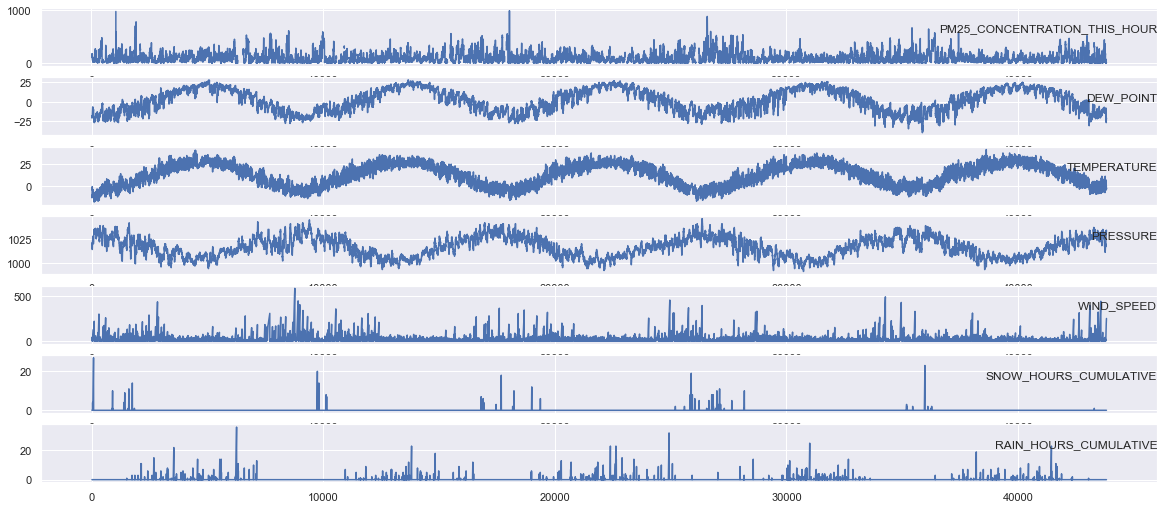

In [11]:
plt.figure(figsize=(20,10))

index_of_cols = list(range(0,len(df_raw.columns.tolist())))
these_values = df_raw.values

subplot_num = 1
for col_no in index_of_cols:
    if col_no!=4: # ignore column WIND_DIRECTION
        plt.subplot(len(index_of_cols), 1, subplot_num)
        plt.plot(these_values[:, col_no])
        plt.title(df_raw.columns[col_no], y=0.5, loc='right')
        subplot_num+=1
    
    
plt.show()

Some trends in the data.

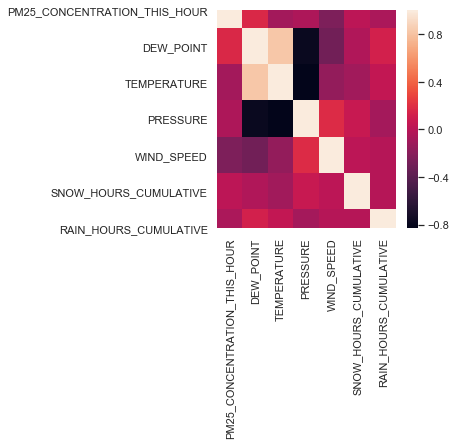

In [12]:
plt.figure(figsize=(4,4))
sns.heatmap(df_raw.corr())

Some very strong relationships between PRESSURE, DEW_POINT, TEMPERATURE. However, VIF scores indicate low levels of multicollinearity, as shown below.

https://etav.github.io/python/vif_factor_python.html

In [13]:
dummy_df = pd.DataFrame(df_raw[['PRESSURE', 'DEW_POINT']])
dummy_df_cor = dummy_df.corr()
pd.DataFrame(np.linalg.inv(dummy_df.corr().values), index = dummy_df_cor.index, columns=dummy_df_cor.columns)

,PRESSURE,DEW_POINT
PRESSURE,2.536929,1.974609
DEW_POINT,1.974609,2.536929


In [14]:
dummy_df = pd.DataFrame(df_raw[['PRESSURE', 'TEMPERATURE']])

dummy_df_cor = dummy_df.corr()
pd.DataFrame(np.linalg.inv(dummy_df.corr().values), index = dummy_df_cor.index, columns=dummy_df_cor.columns)

,PRESSURE,TEMPERATURE
PRESSURE,3.158729,2.611291
TEMPERATURE,2.611291,3.158729


### > PM25_CONCENTRATION_THIS_HOUR vs various factors

In [15]:
temp_df = df_raw.copy()
#temp_df['POLLUTION_INDEX'] = temp_df.apply(lambda row: np.ceil(row['POLLUTION_INDEX'] / 100) * 100 if row['POLLUTION_INDEX']>400 else np.ceil(row['POLLUTION_INDEX'] / 50) * 50,axis=1)
temp_df['PM25_CONCENTRATION_THIS_HOUR'] =  np.ceil(temp_df['PM25_CONCENTRATION_THIS_HOUR']/100) *100
temp_df['DEW_POINT'] = np.ceil(temp_df['DEW_POINT']/10) *10
temp_df['TEMPERATURE'] = np.ceil(temp_df['TEMPERATURE']/10) *10
temp_df['PRESSURE'] = np.ceil(temp_df['PRESSURE']/10) *10
temp_df['WIND_SPEED'] = np.ceil(temp_df['WIND_SPEED']/100) *100
temp_df['SNOW_HOURS_CUMULATIVE'] = np.ceil(temp_df['SNOW_HOURS_CUMULATIVE']/5) *5
temp_df['RAIN_HOURS_CUMULATIVE'] = np.ceil(temp_df['RAIN_HOURS_CUMULATIVE']/5) *5

In [16]:
def plot_PM25_CONCENTRATION_THIS_HOUR_vs_others(feature_name):
    temp_crosstab = pd.crosstab(temp_df[feature_name], temp_df['PM25_CONCENTRATION_THIS_HOUR']).apply(lambda row: round(row/row.sum(),2) * 100, axis=1)
    sns.set(rc={'figure.figsize':(12,4)})
    ax = temp_crosstab.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
    plt.title("POLLUTION_INDEX vs {}".format(feature_name), fontsize=18)
    plt.xlabel("{}".format(feature_name), fontsize=18);
    plt.ylabel("Percentage (%)", fontsize=18)

    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.02, p.get_height() * 1.02))

    plt.show()
    print("\n\n\n")

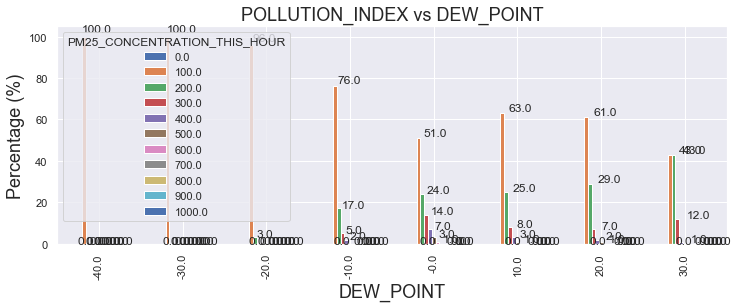

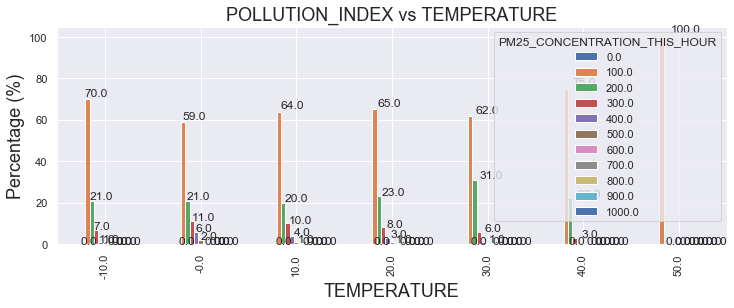

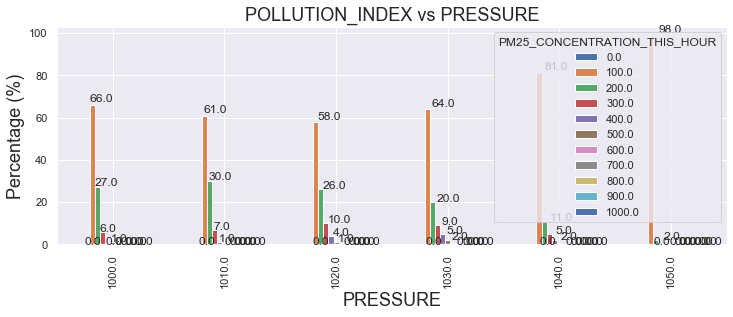

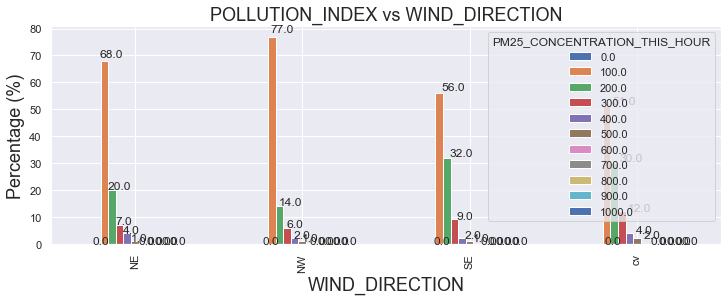

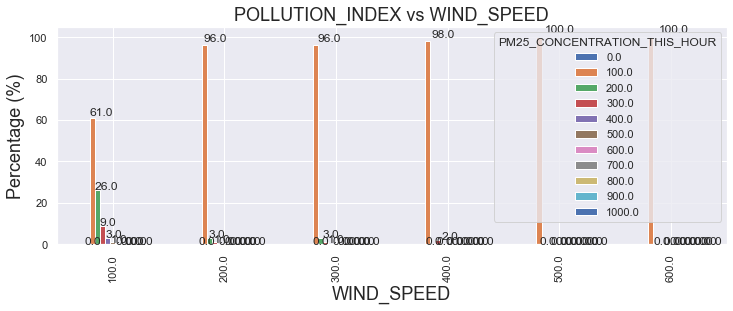

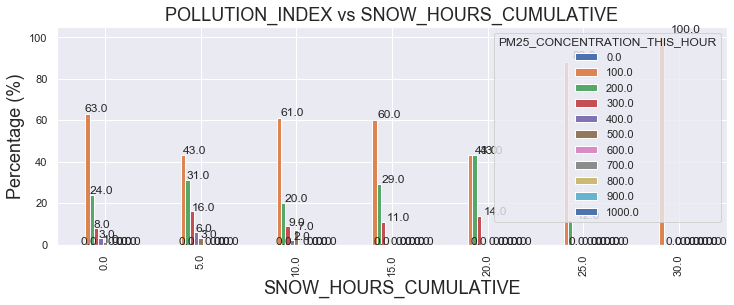

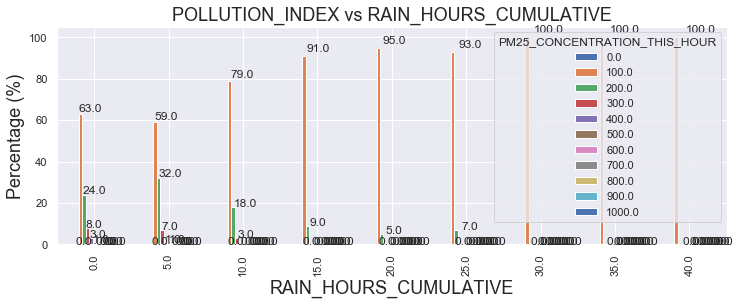

In [17]:
for col_name in temp_df.columns.tolist()[1:]:
    plot_PM25_CONCENTRATION_THIS_HOUR_vs_others(col_name)

- Lower dew_points almost exclusively have lower PM25 levels
- Not clear interpreration on temperature, pressure
- Strong wind speeds result in lower PM25 levels
- Periods of extended continuous snow or rainfall result in lower Pm25 levels but need to be reminded that extended periods are not common.

<h2>3) Data transformation and feature engineering</h2>

When we shift ie create lagging factors, we should not be normalising features on on individual lag columns. Instead the lag columns should be normalised based on their original present day columns.

Furthermore, we should only use the training data to fit_transform the normaliser. Therefore, we will have to do the train-validation-test split before we proceed any further.

Once we split, we will normalise, then bring everything back together before we shift.

### > Train-validation-test split : initial split to normalise features

https://stackoverflow.com/questions/46308374/what-is-validation-data-used-for-in-a-keras-sequential-model/46308466

In [18]:
# get row indices for train, validation, test
rows_for_train = np.math.ceil(len(df_raw)*0.8)
rows_for_valid = np.math.ceil(0.5*(len(df_raw) - rows_for_train))
rows_for_test = len(df_raw) - rows_for_train - rows_for_valid

print(len(df_raw),rows_for_train,rows_for_valid,rows_for_test)

43824 35060 4382 4382


In [19]:
# do not shuffle split as we want training, validation test to be sequential

train = df_raw.iloc[0:rows_for_train]
X_train = train.loc[:, df_raw.columns != 'PM25_CONCENTRATION_THIS_HOUR']
y_train = train.loc[:, df_raw.columns == 'PM25_CONCENTRATION_THIS_HOUR']

validation = df_raw.iloc[rows_for_train:rows_for_train+rows_for_valid]
X_validation = validation.loc[:, df_raw.columns != 'PM25_CONCENTRATION_THIS_HOUR']
y_validation = validation.loc[:, df_raw.columns == 'PM25_CONCENTRATION_THIS_HOUR']

test = df_raw.iloc[rows_for_train+rows_for_valid:]
X_test = test.loc[:, df_raw.columns != 'PM25_CONCENTRATION_THIS_HOUR']
y_test= test.loc[:, df_raw.columns == 'PM25_CONCENTRATION_THIS_HOUR']

# save indexes
X_train_indexes = X_train.index.tolist()
X_validation_indexes = X_validation.index.tolist()
X_test_indexes = X_test.index.tolist()

print(len(X_train),len(y_train),len(X_validation),len(y_validation),len(X_test),len(y_test))

35060 35060 4382 4382 4382 4382


### > Feature scaling

From earlier sections, we know that data are on different scales. Therefore, we will normalise the features. This should help improve model performance.

In [20]:
# A class to select numerical or categorical columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [21]:
# create list of numerical and categorical columns
numerical_cols = list(X_train.columns)
numerical_cols.remove('WIND_DIRECTION')
categorical_cols = ['WIND_DIRECTION']

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numerical_cols)),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(categorical_cols)),
    ("cat_encoder",  OneHotEncoder())
])

# https://stackoverflow.com/a/52666039
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [22]:
# fit and transform X_train
X_train_transformed = preprocess_pipeline.fit_transform(X_train).toarray()

# transform X_validation based on transformer fitted on X_train
X_validation_transformed = preprocess_pipeline.transform(X_validation).toarray()

# transform X_test based on transformer fitted on X_train
X_test_transformed = preprocess_pipeline.transform(X_test).toarray()

In [23]:
# store the features names (also in case we want to use XGBoost or LightGBM)
feature_names = numerical_cols.copy()
feature_names.extend([col for col in categorical_pipeline["cat_encoder"].get_feature_names()])

In [24]:
# bring everything backtogether

train = pd.DataFrame(X_train_transformed, columns=feature_names)
train['PM25_CONCENTRATION_THIS_HOUR'] = y_train.values
train['DATETIME'] = X_train_indexes
train['TAG'] = 'TRAIN'

validation = pd.DataFrame(X_validation_transformed, columns=feature_names)
validation['PM25_CONCENTRATION_THIS_HOUR'] = y_validation.values
validation['DATETIME'] = X_validation_indexes
validation['TAG'] = 'VALIDATION'

test = pd.DataFrame(X_test_transformed, columns=feature_names)
test['PM25_CONCENTRATION_THIS_HOUR'] = y_test.values
test['DATETIME'] = X_test_indexes
test['TAG'] = 'TEST'

df_normalised = train.append(validation)
df_normalised = df_normalised.append(test)
df_normalised = df_normalised.set_index('DATETIME').sort_index()
print(len(df_normalised))

43824


In [25]:
df_normalised.head()

,DEW_POINT,TEMPERATURE,PRESSURE,WIND_SPEED,SNOW_HOURS_CUMULATIVE,RAIN_HOURS_CUMULATIVE,x0_NE,x0_NW,x0_SE,x0_cv,PM25_CONCENTRATION_THIS_HOUR,TAG
DATETIME,,,,,,,,,,,,
2010-01-01 00:00:00,-1.569889,-1.879367,0.442977,-0.451433,-0.074255,-0.140823,0.0,1.0,0.0,0.0,NaN,TRAIN
2010-01-01 01:00:00,-1.569889,-1.960579,0.346668,-0.390408,-0.074255,-0.140823,0.0,1.0,0.0,0.0,NaN,TRAIN
2010-01-01 02:00:00,-1.569889,-1.879367,0.250358,-0.355509,-0.074255,-0.140823,0.0,1.0,0.0,0.0,NaN,TRAIN
2010-01-01 03:00:00,-1.569889,-2.123002,0.250358,-0.294484,-0.074255,-0.140823,0.0,1.0,0.0,0.0,NaN,TRAIN
2010-01-01 04:00:00,-1.500916,-1.960579,0.154049,-0.233459,-0.074255,-0.140823,0.0,1.0,0.0,0.0,NaN,TRAIN


### > Log transform target variable

Distribution of Y-variable is non-normal. We can use it's log to transform.

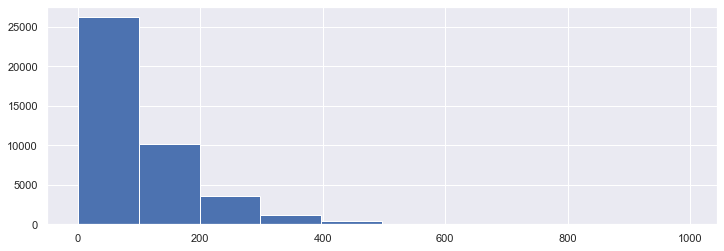

In [26]:
df_normalised.PM25_CONCENTRATION_THIS_HOUR.hist()

In [27]:
df_normalised.PM25_CONCENTRATION_THIS_HOUR = np.log1p(df_normalised.PM25_CONCENTRATION_THIS_HOUR)

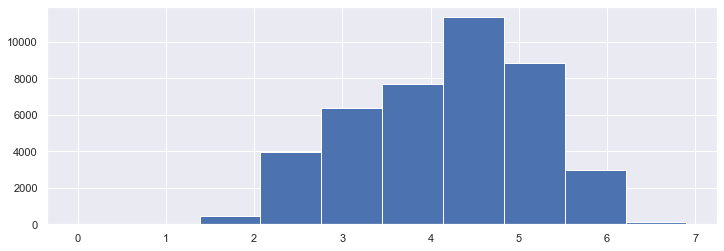

In [28]:
df_normalised.PM25_CONCENTRATION_THIS_HOUR.hist()

From the above, we see that the Y-variable is approx. normal. This will help improve model performance.

### > Study distributions of data

Post our transformations, we see that our dataset is a closer to being normally distributed.

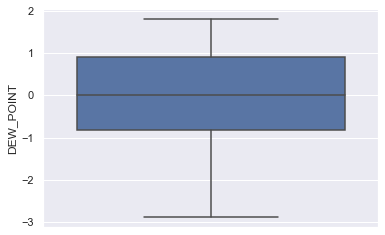

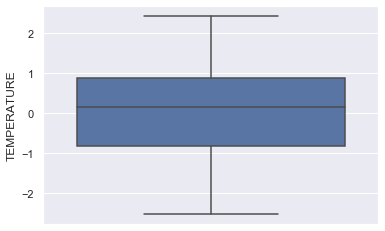

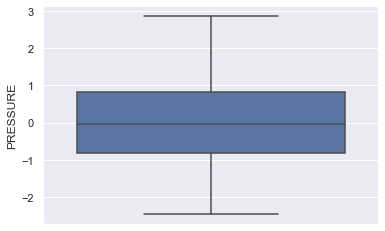

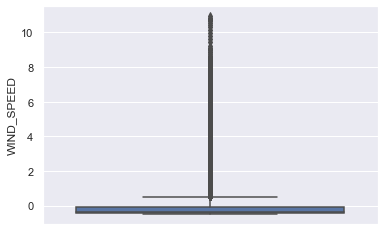

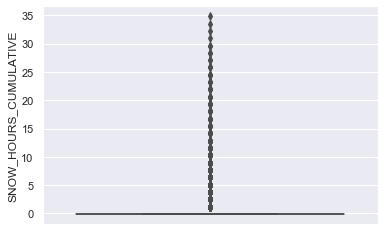

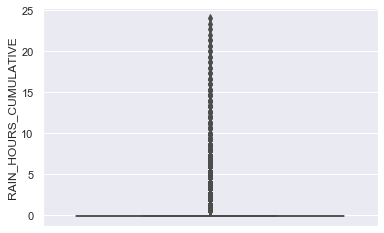

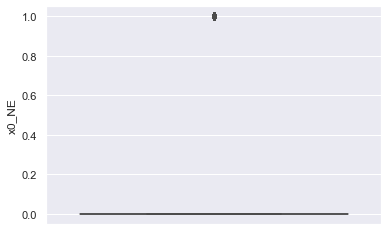

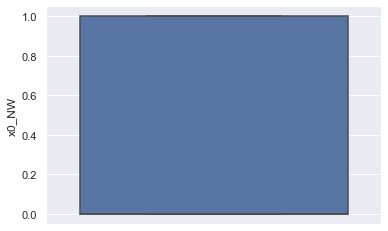

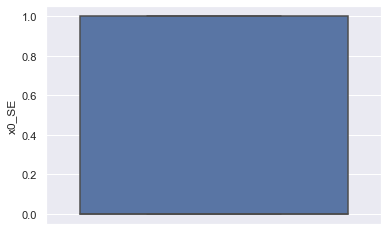

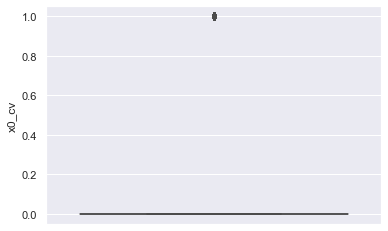

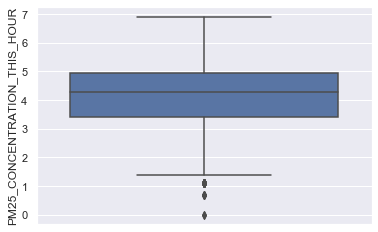

In [29]:
# use seaborn to preserve memory. Standard matplotlib.pyplot consumes alot of memory.
sns.set(rc={'figure.figsize':(6,4)})
for column in df_normalised.columns:
    if df_normalised[column].dtype != 'object':
        sns.boxplot(y=df_normalised[column])
        plt.show()

### > K-means clustering

A recent technique I learnt at work from our Lead Data Scientist is to introduce a new feature which are the labels from a kmeans clustering. Hopefully this will improve model performance.

Note that in real-life, we would have to rerun this clustering each hour we receive new data. However, for this notebook, we will proceed with these labels.

1
2
3
4
5
6
7
8
9


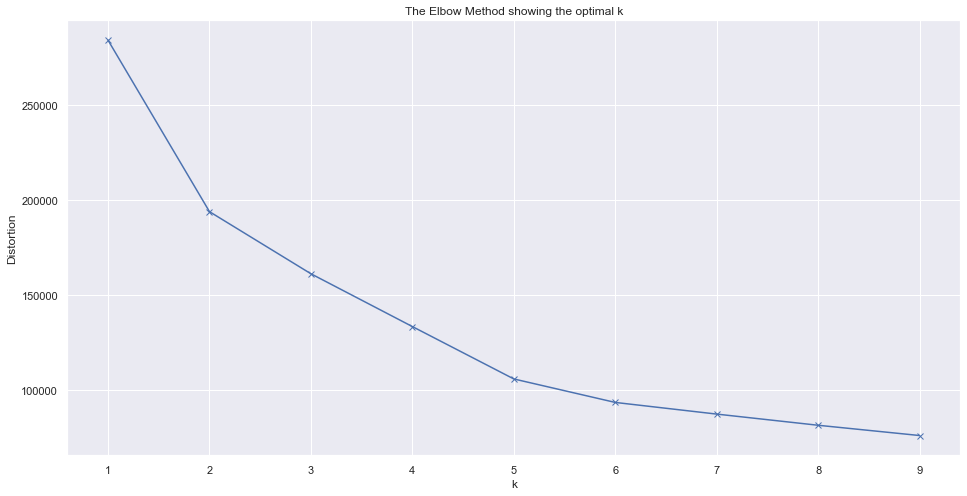

In [30]:
prev_values = df_normalised[df_normalised.columns.difference(['PM25_CONCENTRATION_THIS_HOUR','TAG'])].copy().values

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(prev_values)
    distortions.append(kmeanModel.inertia_)
    print(k)
    
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the above, 5 clusters seems to be a reasonble elbow.

In [31]:
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(prev_values)
kmeans_labels = list(kmeanModel.labels_)
df_normalised['kmeans_labels'] = kmeans_labels

In [32]:
# # uncomment these sells to sort corrs and filter higher corrs
# # https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

# corr_matrix = df_shifted.corr().abs()

# #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
# sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#                  .stack()
#                  .sort_values(ascending=False))
# #first element of sol series is the pair with the bigest correlation

# df_corrs = pd.DataFrame(sol.reset_index())
# df_corrs = df_corrs.rename(columns={'level_0':"VAR1", 'level_1':"VAR2", 0:"CORRS"})
# df_corrs

### > Create lagging factors

Since we would like to predict the air pollution in the next hour, we will have to at the very least previous hour's data. We can also consider lagging further back into the past. We will perform a few tests to determine a possible lagging period.

#### >> Understand autocorrelations to figure out how far back we want to lag previous PM25 values.

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

From the plot below, it looks like 15 hours seems like a good limit.

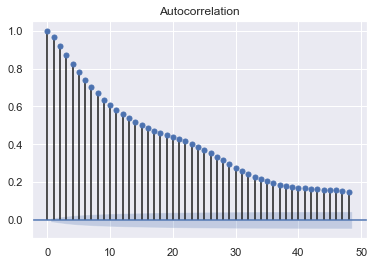

In [33]:
plot_acf(df_raw[~df_raw['PM25_CONCENTRATION_THIS_HOUR'].isnull()]['PM25_CONCENTRATION_THIS_HOUR'],lags=48)
plt.show()

#### >> Create lags

In [34]:
cols_to_shift = df_normalised.columns.tolist()
cols_to_shift.remove('TAG')
timestep = 10
lagging_periods = timestep + 1

df_shifted = df_normalised.copy()

for lagger in range(1,lagging_periods):
    temp_shifted = pd.DataFrame(df_shifted[cols_to_shift].shift(+lagger,freq='H'))
    df_shifted = df_shifted.join(temp_shifted.rename(columns=lambda x: x+"_lag_{}".format(str(lagger))))

#df_shifted.to_csv('dummy.csv')

# temp_shifted = pd.DataFrame(df_shifted['PM25_CONCENTRATION_THIS_HOUR'].shift(-1,freq='H'))
# df_shifted = df_shifted.join(temp_shifted.rename(columns=lambda x: 'PM25_CONCENTRATION_NEXT_HOUR'))

### > Handle missing values

If we do not drop rows with missing target values, we can use a flag to inform our LSTM to mask this ie not use it as an input 

https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/

In [35]:
print(len(df_shifted))

# #use next line if we want to remove rows where pm25 is missing
# here we remove examples with missing target values
df_shifted = df_shifted[~df_shifted['PM25_CONCENTRATION_THIS_HOUR'].isnull()]
# for an example, there may be instances where the lagging PM25 may be missing. We replace these lagging PM25 with -999999
# our model will mask these features
# note that we will still be able to gain information on the other lagging features for
# the timestep which had missing lagging PM25
df_shifted = df_shifted.fillna(-999999)

# #use next line if we want to replace null pm25 with zeros
# df_shifted = df_shifted.fillna(0)

# print(len(df_shifted))

43824


### > Train-test split: final split for model development

In [36]:
# drop this hour's features. We are supposed 'blind' this hour
df_shifted.drop(['DEW_POINT',
 'TEMPERATURE',
 'PRESSURE',
 'WIND_SPEED',
 'SNOW_HOURS_CUMULATIVE',
 'RAIN_HOURS_CUMULATIVE',
 'x0_NE',
 'x0_NW',
 'x0_SE',
 'x0_cv'],axis=1,inplace=True)

In the next cell, we ignore the rows where all features are missing. The reason for this is we collapse the 15 sets of lag columns into 15 rows for each time step. If all 15 columns are missing, then all rows in that timestep is missing. Given that a timestep is in effect 1 example for an LSTM, this will result in an example of just missing values. If we do this, we will hit this error:

"UnknownError: [_Derived_] CUDNN_STATUS_BAD_PARAM in tensorflow/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDataDescriptor( data_desc.get(), data_type, layout, max_seq_length, batch_size, data_size, seq_lengths_array, (void*)&padding_fill)' [[{{node cond_64/then/_0/CudnnRNNV3}}]] [[sequential_5/lstm_1/StatefulPartitionedCall]] [Op:__inference_distributed_function_10159] Function call stack: distributed_function -> distributed_function -> distributed_function"

The hint for our solution came from: https://github.com/tensorflow/tensorflow/issues/33069

In [37]:
df_shifted[(df_shifted.loc[:,df_shifted.columns != 'TAG'] == 0).all(axis='columns')]

,PM25_CONCENTRATION_THIS_HOUR,TAG,kmeans_labels,DEW_POINT_lag_1,TEMPERATURE_lag_1,PRESSURE_lag_1,WIND_SPEED_lag_1,SNOW_HOURS_CUMULATIVE_lag_1,RAIN_HOURS_CUMULATIVE_lag_1,x0_NE_lag_1,...,PRESSURE_lag_10,WIND_SPEED_lag_10,SNOW_HOURS_CUMULATIVE_lag_10,RAIN_HOURS_CUMULATIVE_lag_10,x0_NE_lag_10,x0_NW_lag_10,x0_SE_lag_10,x0_cv_lag_10,PM25_CONCENTRATION_THIS_HOUR_lag_10,kmeans_labels_lag_10
DATETIME,,,,,,,,,,,,,,,,,,,,,


In [38]:
df_shifted = df_shifted[~(df_shifted.loc[:,df_shifted.columns != 'TAG'] == 0).all(axis='columns')].copy()
len(df_shifted)

41757

"If you want to build a solid model you have to follow that specific protocol of splitting your data into three sets: One for training, one for validation and one for final evalution, which is the test set.

The idea is that you train on your training data and tune your model with the results of metrics (accuracy, loss etc) that you get from your validation set.

Your model doesn't "see" your validation set and isn´t in any way trained on it, but you as the architect and master of the hyperparameters tune the model according to this data. Therefore it indirectly influences your model because it directly influences your design decisions. You nudge your model to work well with the validation data and that can possibly bring in a tilt.

Exactly that is the reason you only evaluate your models final score on data that neither your model nor you yourself has used – and that is the third chunk of data, your test set.

Only this procedure makes sure you get an unaffected view of your models quality and ability to generalize what is has learned on totally unseen data." - [@petezurich](https://stackoverflow.com/users/7117003/petezurich), https://stackoverflow.com/a/46308466

In [39]:
# rearrange columns
cols_list = df_shifted.columns.tolist()
cols_list.remove('PM25_CONCENTRATION_THIS_HOUR')
cols_list.append('PM25_CONCENTRATION_THIS_HOUR')
df_shifted = df_shifted[cols_list]

# # integer encode direction
# encoder = LabelEncoder()
# df_shifted['PM25_CONCENTRATION_NEXT_HOUR'] = encoder.fit_transform(df_shifted['PM25_CONCENTRATION_NEXT_HOUR'])

# create train array
train = df_shifted[df_shifted.TAG=='TRAIN']
train = train.drop('TAG',axis=1)
train = train.drop('kmeans_labels',axis=1)
print(train.columns.tolist()[-1])
train_values = train.values
train_values = train_values.astype('float32')

# create validation array
validation = df_shifted[df_shifted.TAG=='VALIDATION']
validation = validation.drop('TAG',axis=1)
validation = validation.drop('kmeans_labels',axis=1)
print(validation.columns.tolist()[-1])
validation_values = validation.values
validation_values = validation_values.astype('float32')

# create test array
test = df_shifted[df_shifted.TAG=='TEST']
test = test.drop('TAG',axis=1)
test = test.drop('kmeans_labels',axis=1)
print(test.columns.tolist()[-1])
test_values = test.values
test_values = test_values.astype('float32')

# create Xs and ys
X_train = train_values[:, :-1]
y_train = train_values[:, -1]
X_validation = validation_values[:, :-1]
y_validation = validation_values[:, -1]
X_test = test_values[:, :-1]
y_test = test_values[:, -1]

print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

PM25_CONCENTRATION_THIS_HOUR
PM25_CONCENTRATION_THIS_HOUR
PM25_CONCENTRATION_THIS_HOUR
(33092, 120) (33092,) (4349, 120) (4349,) (4316, 120) (4316,)


Reshape into 35060 rows (or 4382 rows for validation and test set), where each row contains n time rows itself, of 11 features

- https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://stackoverflow.com/questions/38714959/understanding-keras-lstms

In [40]:
X_train_reshaped = X_train.reshape(X_train.shape[0], timestep, 12)
X_validation_reshaped = X_validation.reshape(X_validation.shape[0], timestep, 12)
X_test_reshaped = X_test.reshape(X_test.shape[0], timestep, 12)

print(X_train_reshaped.shape,y_train.shape,X_validation_reshaped.shape,y_validation.shape,X_test_reshaped.shape,y_test.shape)

(33092, 10, 12) (33092,) (4349, 10, 12) (4349,) (4316, 10, 12) (4316,)


<h2> 4) Model development </h2>

We instantiate a shallow neural network, based on the arhitecture from https://machinelearningmastery.com/.

In [228]:
# define model
try_mask = "yes" # or "yes" or no"
  
model = Sequential()

if try_mask == "yes": # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50))
    
else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

For some reason, MAPE is very high. I think the training predictions are not being made properly.

https://stackoverflow.com/questions/49729522/why-is-the-mean-average-percentage-errormape-extremely-high

If we hit:

"keras Unknown Error: [_Derived_] Fail to find the dnn implementation. [[{{node CudnnRNN}}]] [[sequential_2/lstm_2/StatefulPartitionedCall]] [Op:__inference_distributed_function_10056] Function call stack: distributed_function -> distributed_function -> distributed_function"

this is because another process is running on our GPU.

https://github.com/keras-team/keras/issues/10634#issuecomment-494157136

In [229]:
# fit network
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
# verbose 0, 1, 2 https://stackoverflow.com/questions/47902295/what-is-the-use-of-verbose-in-keras-while-validating-the-model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 15s 439us/sample - loss: 0.9891 - mse: 0.9891 - mae: 0.6610 - val_loss: 0.6064 - val_mse: 0.6064 - val_mae: 0.6127
Epoch 2/50
33092/33092 [==============================] - 5s 160us/sample - loss: 0.3675 - mse: 0.3675 - mae: 0.3946 - val_loss: 0.2926 - val_mse: 0.2926 - val_mae: 0.4027
Epoch 3/50
33092/33092 [==============================] - 5s 164us/sample - loss: 0.2444 - mse: 0.2444 - mae: 0.3212 - val_loss: 0.2131 - val_mse: 0.2131 - val_mae: 0.3468
Epoch 4/50
33092/33092 [==============================] - 5s 161us/sample - loss: 0.1776 - mse: 0.1776 - mae: 0.2818 - val_loss: 0.1574 - val_mse: 0.1574 - val_mae: 0.2940
Epoch 5/50
33092/33092 [==============================] - 5s 158us/sample - loss: 0.1417 - mse: 0.1417 - mae: 0.2566 - val_loss: 0.1205 - val_mse: 0.1205 - val_mae: 0.2457
Epoch 6/50
33092/33092 [==============================] - 5s 156us/sample - loss: 0.1243 -

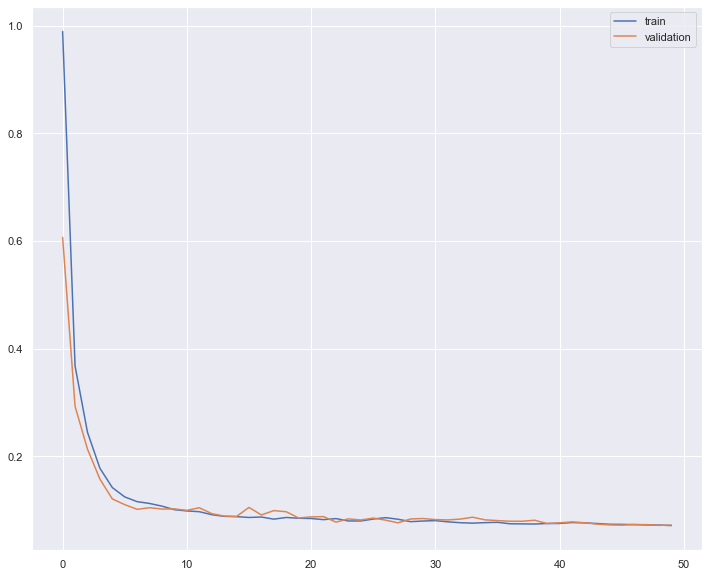

In [230]:
sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

From the above, our training and validation loss are approaching the same levels. We can conclude that the model is neither overfitting nor underfitting.

In [231]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.08662949
RMSE:  0.29432887655495255
MASE:  12.730228
MAPE:  25.45577860699102 %


We do quite well on our test set loss. Let's experiment tuning our model.

## 5) Model tuning

https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

### > Tune batch size

From the graph above, we see that the loss has stabilised. Therefore, we will not increase the number of epochs.

Let's see if we can get a performance gain from changing the batch sizes which will mean changes in our weights and therefore output accuracy either more rapidly or slowly. 

In [240]:
dict_batch_size_train_losses = {}
dict_batch_size_val_losses = {}

for this_batch_size in [50,72,100,150,200]:
    
    print(this_batch_size)

    # define model
    try_mask = "yes" # or "yes" or no"

    model = Sequential()

    if try_mask == "yes":
        # if we want to mask our missing values
        model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(LSTM(50))

    else:
        model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))


    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
    
    history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=this_batch_size, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)
    
    dict_batch_size_train_losses[this_batch_size] = history.history['loss']
    dict_batch_size_val_losses[this_batch_size] = history.history['val_loss']

50
Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 18s 543us/sample - loss: 0.9347 - mse: 0.9347 - mae: 0.6232 - val_loss: 0.4789 - val_mse: 0.4789 - val_mae: 0.5202
Epoch 2/50
33092/33092 [==============================] - 8s 231us/sample - loss: 0.4007 - mse: 0.4007 - mae: 0.3741 - val_loss: 0.3501 - val_mse: 0.3501 - val_mae: 0.4454
Epoch 3/50
33092/33092 [==============================] - 8s 229us/sample - loss: 0.3076 - mse: 0.3076 - mae: 0.3120 - val_loss: 0.2200 - val_mse: 0.2200 - val_mae: 0.3435
Epoch 4/50
33092/33092 [==============================] - 7s 223us/sample - loss: 0.2262 - mse: 0.2262 - mae: 0.2774 - val_loss: 0.1668 - val_mse: 0.1668 - val_mae: 0.2954
Epoch 5/50
33092/33092 [==============================] - 7s 221us/sample - loss: 0.1555 - mse: 0.1555 - mae: 0.2506 - val_loss: 0.1329 - val_mse: 0.1329 - val_mae: 0.2641
Epoch 6/50
33092/33092 [==============================] - 7s 222us/sample - loss: 0.130

33092/33092 [==============================] - 5s 161us/sample - loss: 0.0711 - mse: 0.0711 - mae: 0.1821 - val_loss: 0.0729 - val_mse: 0.0729 - val_mae: 0.1793
Epoch 46/50
33092/33092 [==============================] - 5s 161us/sample - loss: 0.0708 - mse: 0.0708 - mae: 0.1821 - val_loss: 0.0711 - val_mse: 0.0711 - val_mae: 0.1758
Epoch 47/50
33092/33092 [==============================] - 5s 161us/sample - loss: 0.0709 - mse: 0.0709 - mae: 0.1819 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.1753
Epoch 48/50
33092/33092 [==============================] - 5s 161us/sample - loss: 0.0701 - mse: 0.0701 - mae: 0.1809 - val_loss: 0.0693 - val_mse: 0.0693 - val_mae: 0.1732
Epoch 49/50
33092/33092 [==============================] - 5s 161us/sample - loss: 0.0701 - mse: 0.0701 - mae: 0.1809 - val_loss: 0.0711 - val_mse: 0.0711 - val_mae: 0.1762
Epoch 50/50
33092/33092 [==============================] - 5s 162us/sample - loss: 0.0697 - mse: 0.0697 - mae: 0.1804 - val_loss: 0.0702 - val_mse:

33092/33092 [==============================] - 3s 80us/sample - loss: 0.1334 - mse: 0.1334 - mae: 0.2769 - val_loss: 0.1575 - val_mse: 0.1575 - val_mae: 0.2986
Epoch 40/50
33092/33092 [==============================] - 3s 83us/sample - loss: 0.1141 - mse: 0.1141 - mae: 0.2475 - val_loss: 0.0859 - val_mse: 0.0859 - val_mae: 0.2024
Epoch 41/50
33092/33092 [==============================] - 3s 80us/sample - loss: 0.0885 - mse: 0.0885 - mae: 0.2050 - val_loss: 0.1032 - val_mse: 0.1032 - val_mae: 0.2438
Epoch 42/50
33092/33092 [==============================] - 3s 80us/sample - loss: 0.0987 - mse: 0.0987 - mae: 0.2255 - val_loss: 0.4192 - val_mse: 0.4192 - val_mae: 0.5356
Epoch 43/50
33092/33092 [==============================] - 3s 80us/sample - loss: 0.1624 - mse: 0.1624 - mae: 0.3107 - val_loss: 0.2131 - val_mse: 0.2131 - val_mae: 0.3698
Epoch 44/50
33092/33092 [==============================] - 3s 79us/sample - loss: 0.1210 - mse: 0.1210 - mae: 0.2565 - val_loss: 0.1459 - val_mse: 0.145

Plot training and validation lossses for each batch size separately. 

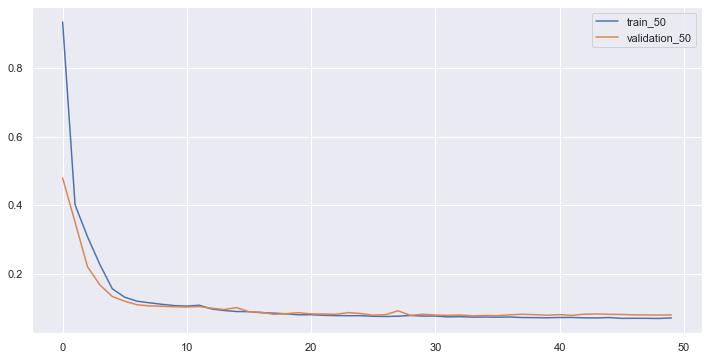

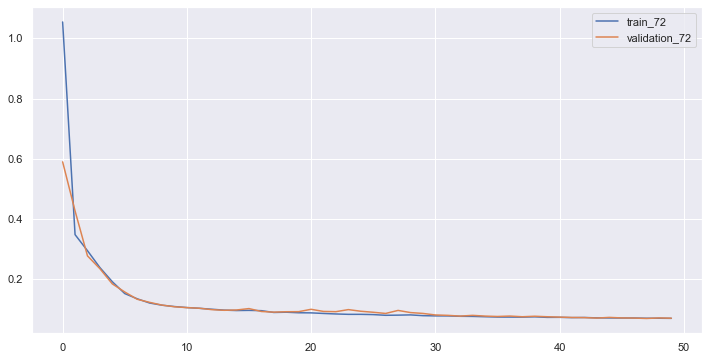

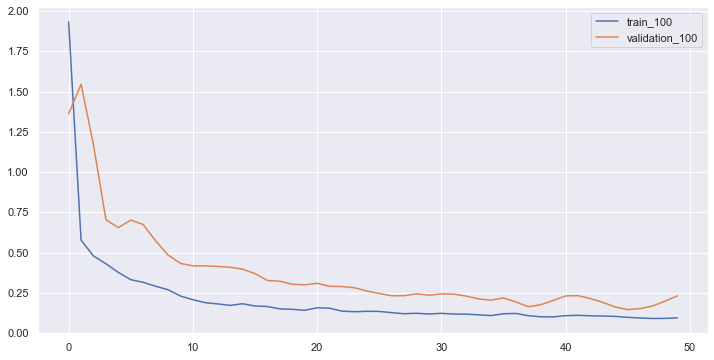

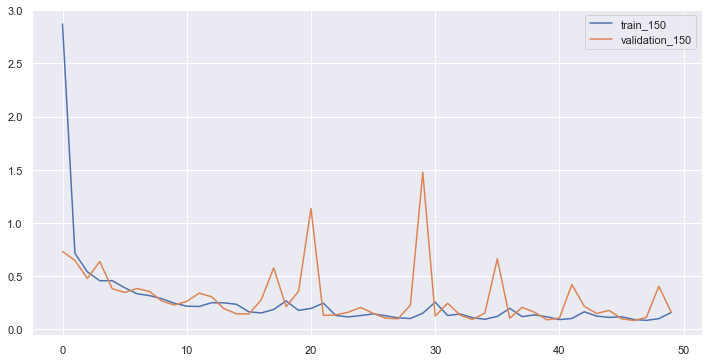

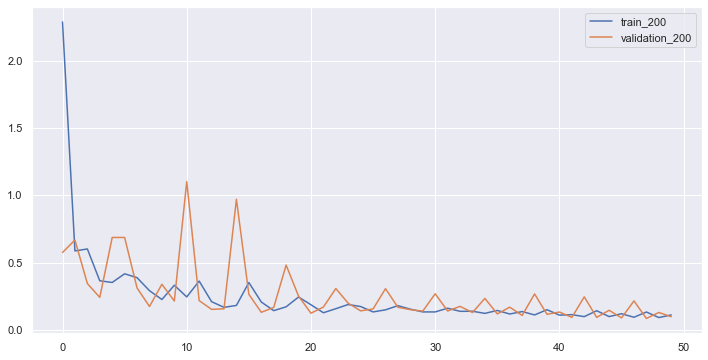

In [244]:
sns.set(rc={'figure.figsize':(12,6)})
for this_batch_size in dict_batch_size_train_losses:
    plt.plot(dict_batch_size_train_losses[this_batch_size], label='train_{}'.format(this_batch_size))
    plt.plot(dict_batch_size_val_losses[this_batch_size], label='validation_{}'.format(this_batch_size))
    plt.legend()
    plt.show()

Plot validation losses of each batch size together.

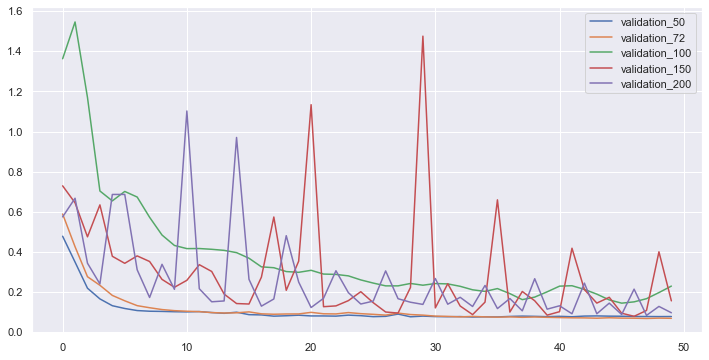

In [247]:
sns.set(rc={'figure.figsize':(12,6)})
for this_batch_size in dict_batch_size_train_losses:
    #plt.plot(dict_batch_size_train_losses[this_batch_size], label='train_{}'.format(this_batch_size))
    plt.plot(dict_batch_size_val_losses[this_batch_size], label='validation_{}'.format(this_batch_size))
plt.legend()
plt.show()

### > Tune no. of neurons.

From the above, we see that after batch sizes 50 and 72 perform best. 72 looks to have the greatest parity between training and validation loss.

Let's try changing the number of neurons. This will allow us to learn more complex relationship but at the expense of overfitting to the training set.

In [246]:
dict_neurons_train_losses = {}
dict_neurons_val_losses = {}

for no_of_neurons in [25,50,75,100]:
    
    print(no_of_neurons)

    # define model
    try_mask = "yes" # or "yes" or no"

    model = Sequential()

    if try_mask == "yes":
        # if we want to mask our missing values
        model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(LSTM(no_of_neurons))

    else:
        model.add(LSTM(no_of_neurons, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))


    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
    
    history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)
    
    dict_neurons_train_losses[no_of_neurons] = history.history['loss']
    dict_neurons_val_losses[no_of_neurons] = history.history['val_loss']

25
Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 16s 481us/sample - loss: 1.3206 - mse: 1.3206 - mae: 0.7965 - val_loss: 0.8636 - val_mse: 0.8636 - val_mae: 0.7578
Epoch 2/50
33092/33092 [==============================] - 5s 164us/sample - loss: 0.3599 - mse: 0.3599 - mae: 0.4127 - val_loss: 0.9873 - val_mse: 0.9873 - val_mae: 0.8172
Epoch 3/50
33092/33092 [==============================] - 5s 165us/sample - loss: 0.2686 - mse: 0.2686 - mae: 0.3503 - val_loss: 0.9121 - val_mse: 0.9121 - val_mae: 0.7898
Epoch 4/50
33092/33092 [==============================] - 5s 159us/sample - loss: 0.2204 - mse: 0.2204 - mae: 0.3141 - val_loss: 0.7793 - val_mse: 0.7793 - val_mae: 0.7306
Epoch 5/50
33092/33092 [==============================] - 5s 155us/sample - loss: 0.2406 - mse: 0.2406 - mae: 0.3035 - val_loss: 0.6880 - val_mse: 0.6880 - val_mae: 0.6810
Epoch 6/50
33092/33092 [==============================] - 5s 154us/sample - loss: 0.230

33092/33092 [==============================] - 5s 162us/sample - loss: 0.0729 - mse: 0.0729 - mae: 0.1831 - val_loss: 0.0734 - val_mse: 0.0734 - val_mae: 0.1804
Epoch 46/50
33092/33092 [==============================] - 5s 162us/sample - loss: 0.0721 - mse: 0.0721 - mae: 0.1822 - val_loss: 0.0728 - val_mse: 0.0728 - val_mae: 0.1795
Epoch 47/50
33092/33092 [==============================] - 5s 161us/sample - loss: 0.0733 - mse: 0.0733 - mae: 0.1833 - val_loss: 0.0746 - val_mse: 0.0746 - val_mae: 0.1821
Epoch 48/50
33092/33092 [==============================] - 5s 160us/sample - loss: 0.0721 - mse: 0.0721 - mae: 0.1818 - val_loss: 0.0793 - val_mse: 0.0793 - val_mae: 0.1867
Epoch 49/50
33092/33092 [==============================] - 5s 165us/sample - loss: 0.0718 - mse: 0.0718 - mae: 0.1814 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.1849
Epoch 50/50
33092/33092 [==============================] - 5s 160us/sample - loss: 0.0713 - mse: 0.0713 - mae: 0.1809 - val_loss: 0.0740 - val_mse:

33092/33092 [==============================] - 6s 171us/sample - loss: 0.0702 - mse: 0.0702 - mae: 0.1809 - val_loss: 0.0740 - val_mse: 0.0740 - val_mae: 0.1805
Epoch 40/50
33092/33092 [==============================] - 6s 172us/sample - loss: 0.0701 - mse: 0.0701 - mae: 0.1808 - val_loss: 0.0739 - val_mse: 0.0739 - val_mae: 0.1807
Epoch 41/50
33092/33092 [==============================] - 6s 174us/sample - loss: 0.0698 - mse: 0.0698 - mae: 0.1802 - val_loss: 0.0727 - val_mse: 0.0727 - val_mae: 0.1787
Epoch 42/50
33092/33092 [==============================] - 6s 169us/sample - loss: 0.0696 - mse: 0.0696 - mae: 0.1798 - val_loss: 0.0749 - val_mse: 0.0749 - val_mae: 0.1803
Epoch 43/50
33092/33092 [==============================] - 6s 170us/sample - loss: 0.0695 - mse: 0.0695 - mae: 0.1804 - val_loss: 0.0734 - val_mse: 0.0734 - val_mae: 0.1802
Epoch 44/50
33092/33092 [==============================] - 6s 167us/sample - loss: 0.0693 - mse: 0.0693 - mae: 0.1797 - val_loss: 0.0722 - val_mse:

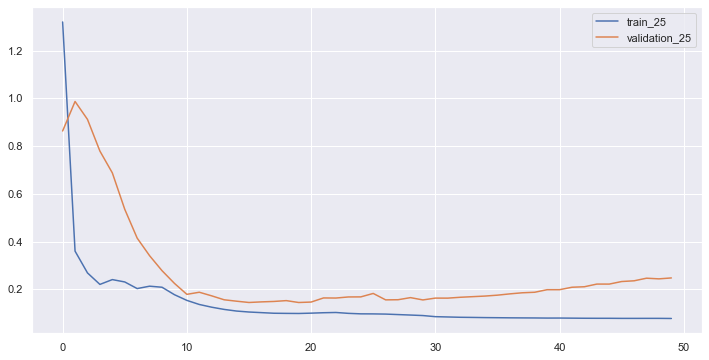

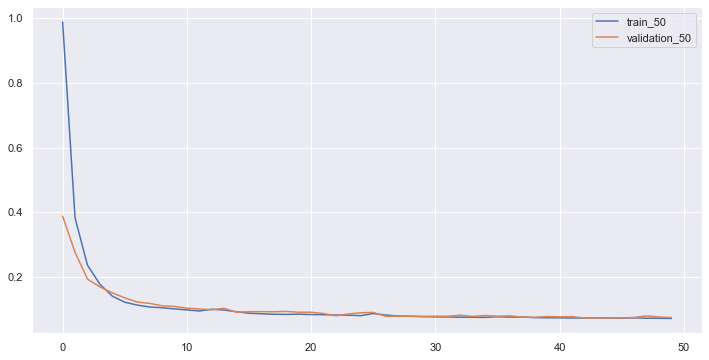

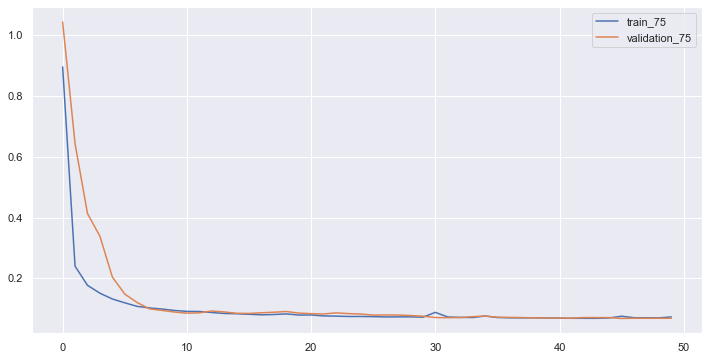

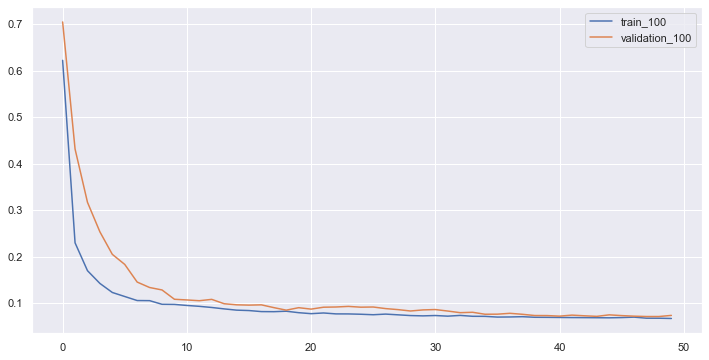

In [249]:
sns.set(rc={'figure.figsize':(12,6)})
for no_of_neurons in dict_neurons_train_losses:
    plt.plot(dict_neurons_train_losses[no_of_neurons], label='train_{}'.format(no_of_neurons))
    plt.plot(dict_neurons_val_losses[no_of_neurons], label='validation_{}'.format(no_of_neurons))
    plt.legend()
    plt.show()

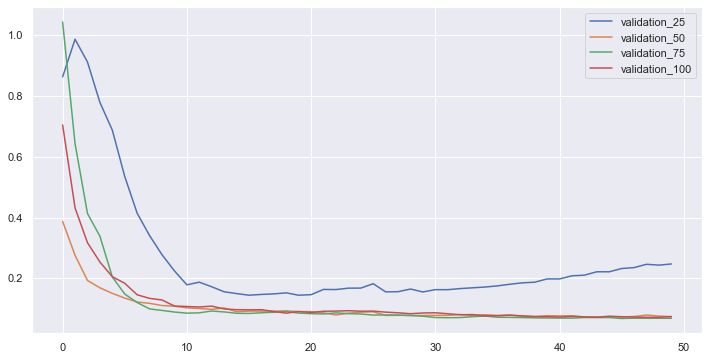

In [250]:
sns.set(rc={'figure.figsize':(12,6)})
for no_of_neurons in dict_neurons_train_losses:
    #plt.plot(dict_neurons_train_losses[no_of_neurons], label='train_{}'.format(no_of_neurons))
    plt.plot(dict_neurons_val_losses[no_of_neurons], label='validation_{}'.format(no_of_neurons))
plt.legend()
plt.show()

From the above, anything above 25 is acceptable. We will stick with 50 neurons to avoid risk of overfitting.

### > Tune input dropout

http://jmlr.org/papers/v15/srivastava14a.html

Exclude neurons during training, to avoid overfitting and to also possible decrease training time.

In [41]:
# define model
try_mask = "yes" # or "yes" or no"

model = Sequential()

if try_mask == "yes":
    # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50,dropout=0.1))

else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 21s 625us/sample - loss: 1.5087 - mse: 1.5087 - mae: 0.7959 - val_loss: 0.9136 - val_mse: 0.9136 - val_mae: 0.7863
Epoch 2/50
33092/33092 [==============================] - 5s 165us/sample - loss: 0.3958 - mse: 0.3958 - mae: 0.4551 - val_loss: 0.9421 - val_mse: 0.9421 - val_mae: 0.7955
Epoch 3/50
33092/33092 [==============================] - 6s 173us/sample - loss: 0.3027 - mse: 0.3027 - mae: 0.4079 - val_loss: 0.9163 - val_mse: 0.9163 - val_mae: 0.7836
Epoch 4/50
33092/33092 [==============================] - 6s 168us/sample - loss: 0.2570 - mse: 0.2570 - mae: 0.3791 - val_loss: 0.8169 - val_mse: 0.8169 - val_mae: 0.7364
Epoch 5/50
33092/33092 [==============================] - 6s 172us/sample - loss: 0.2123 - mse: 0.2123 - mae: 0.3413 - val_loss: 0.6397 - val_mse: 0.6397 - val_mae: 0.6493
Epoch 6/50
33092/33092 [==============================] - 6s 172us/sample - loss: 0.1788 -

33092/33092 [==============================] - 9s 263us/sample - loss: 0.0811 - mse: 0.0811 - mae: 0.1935 - val_loss: 0.1236 - val_mse: 0.1236 - val_mae: 0.2885
Epoch 48/50
33092/33092 [==============================] - 9s 258us/sample - loss: 0.0802 - mse: 0.0802 - mae: 0.1905 - val_loss: 0.1130 - val_mse: 0.1130 - val_mae: 0.2727
Epoch 49/50
33092/33092 [==============================] - 8s 247us/sample - loss: 0.0816 - mse: 0.0816 - mae: 0.1931 - val_loss: 0.1191 - val_mse: 0.1191 - val_mae: 0.2822
Epoch 50/50
33092/33092 [==============================] - 8s 250us/sample - loss: 0.0821 - mse: 0.0821 - mae: 0.1933 - val_loss: 0.1124 - val_mse: 0.1124 - val_mae: 0.2708


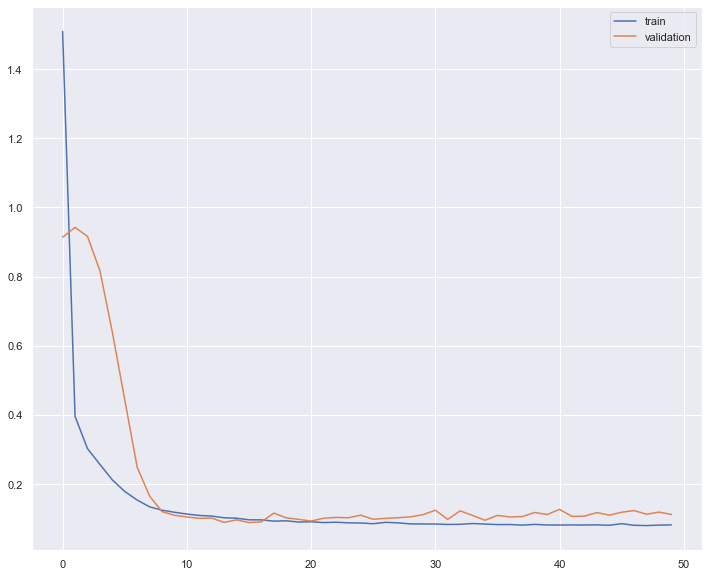

In [42]:
sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [43]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.11095713
RMSE:  0.3331022827747609
MASE:  22.658682
MAPE:  26.37876579275035 %


We see that validation loss is higher than training loss, which means we are overfitting to our training set.

### > Tune recurrent dropout

In [67]:
# define model
try_mask = "yes" # or "yes" or no"

model = Sequential()

if try_mask == "yes":
    # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50,recurrent_dropout=0.1))

else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 33s 992us/sample - loss: 1.1405 - mse: 1.1405 - mae: 0.7179 - val_loss: 1.0851 - val_mse: 1.0851 - val_mae: 0.8429
Epoch 2/50
33092/33092 [==============================] - 24s 714us/sample - loss: 0.4021 - mse: 0.4021 - mae: 0.4317 - val_loss: 0.9824 - val_mse: 0.9824 - val_mae: 0.8080
Epoch 3/50
33092/33092 [==============================] - 23s 704us/sample - loss: 0.2896 - mse: 0.2896 - mae: 0.3581 - val_loss: 0.7282 - val_mse: 0.7282 - val_mae: 0.6997
Epoch 4/50
33092/33092 [==============================] - 24s 720us/sample - loss: 0.2176 - mse: 0.2176 - mae: 0.3092 - val_loss: 0.4979 - val_mse: 0.4979 - val_mae: 0.5664
Epoch 5/50
33092/33092 [==============================] - 25s 744us/sample - loss: 0.1753 - mse: 0.1753 - mae: 0.2833 - val_loss: 0.3783 - val_mse: 0.3783 - val_mae: 0.4934
Epoch 6/50
33092/33092 [==============================] - 22s 657us/sample - loss: 0.1

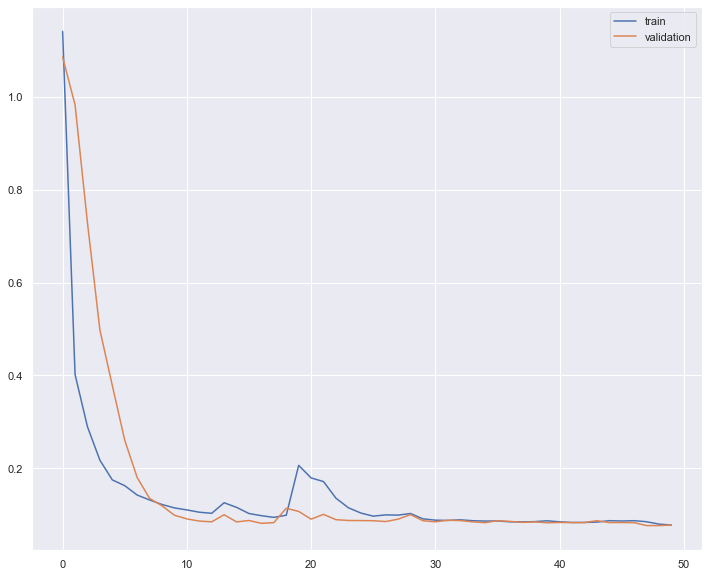

In [68]:
sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [69]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.09248605
RMSE:  0.30411519808325177
MASE:  16.437801
MAPE:  27.392003382395693 %


Not much help in improving performance.

### > Tune stateful

http://philipperemy.github.io/keras-stateful-lstm/

In a stateless LSTM, the memory cells are reset at each batch. If stateful, the memory cells are propagated to the next batch. Retaining statefulness will mean that the model will remember what it predicted for this batch, and will consider this output for when it is passed a new input batch. 

For this, we need to ensure that the trianing and validation set can be divisible by batch size. In this case, we will downsize our dataset.

For further explanations: https://stackoverflow.com/questions/47594861/predicting-a-multiple-forward-time-step-of-a-time-series-using-lstm

In [70]:
# downsize dataset

# rearrange columns
cols_list = df_shifted.columns.tolist()
cols_list.remove('PM25_CONCENTRATION_THIS_HOUR')
cols_list.append('PM25_CONCENTRATION_THIS_HOUR')
df_shifted = df_shifted[cols_list]

# # integer encode direction
# encoder = LabelEncoder()
# df_shifted['PM25_CONCENTRATION_NEXT_HOUR'] = encoder.fit_transform(df_shifted['PM25_CONCENTRATION_NEXT_HOUR'])

# create train array
train = df_shifted[-40000:-8000]
train = train.drop('TAG',axis=1)
train = train.drop('kmeans_labels',axis=1)
print(train.columns.tolist()[-1])
train_values = train.values
train_values = train_values.astype('float32')

# create validation array
validation = df_shifted[-8000:-4000]
validation = validation.drop('TAG',axis=1)
validation = validation.drop('kmeans_labels',axis=1)
print(validation.columns.tolist()[-1])
validation_values = validation.values
validation_values = validation_values.astype('float32')

# create test array
test = df_shifted[-4000:]
test = test.drop('TAG',axis=1)
test = test.drop('kmeans_labels',axis=1)
print(test.columns.tolist()[-1])
test_values = test.values
test_values = test_values.astype('float32')

# create Xs and ys
X_train = train_values[:, :-1]
y_train = train_values[:, -1]
X_validation = validation_values[:, :-1]
y_validation = validation_values[:, -1]
X_test = test_values[:, :-1]
y_test = test_values[:, -1]

print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

X_train_reshaped = X_train.reshape(X_train.shape[0], timestep, 12)
X_validation_reshaped = X_validation.reshape(X_validation.shape[0], timestep, 12)
X_test_reshaped = X_test.reshape(X_test.shape[0], timestep, 12)

print(X_train_reshaped.shape,y_train.shape,X_validation_reshaped.shape,y_validation.shape,X_test_reshaped.shape,y_test.shape)

PM25_CONCENTRATION_THIS_HOUR
PM25_CONCENTRATION_THIS_HOUR
PM25_CONCENTRATION_THIS_HOUR
(32000, 120) (32000,) (4000, 120) (4000,) (4000, 120) (4000,)
(32000, 10, 12) (32000,) (4000, 10, 12) (4000,) (4000, 10, 12) (4000,)


In [71]:
# define model
try_mask = "yes" # or "yes" or no"

batch_size = 50

model = Sequential()

if try_mask == "yes":
    # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, batch_input_shape=(batch_size, X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50, stateful=True))

else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=batch_size, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

Train on 32000 samples, validate on 4000 samples
Epoch 1/50
32000/32000 [==============================] - 45s 1ms/sample - loss: 0.9118 - mse: 0.9118 - mae: 0.6515 - val_loss: 0.7925 - val_mse: 0.7925 - val_mae: 0.7384
Epoch 2/50
32000/32000 [==============================] - 15s 456us/sample - loss: 0.3481 - mse: 0.3481 - mae: 0.4428 - val_loss: 0.5684 - val_mse: 0.5684 - val_mae: 0.5923
Epoch 3/50
32000/32000 [==============================] - 14s 437us/sample - loss: 0.3032 - mse: 0.3032 - mae: 0.4114 - val_loss: 0.5860 - val_mse: 0.5860 - val_mae: 0.6056
Epoch 4/50
32000/32000 [==============================] - 14s 437us/sample - loss: 0.2733 - mse: 0.2733 - mae: 0.3902 - val_loss: 0.5899 - val_mse: 0.5899 - val_mae: 0.6109
Epoch 5/50
32000/32000 [==============================] - 14s 444us/sample - loss: 0.2644 - mse: 0.2644 - mae: 0.3823 - val_loss: 0.5527 - val_mse: 0.5527 - val_mae: 0.5942
Epoch 6/50
32000/32000 [==============================] - 14s 451us/sample - loss: 0.250

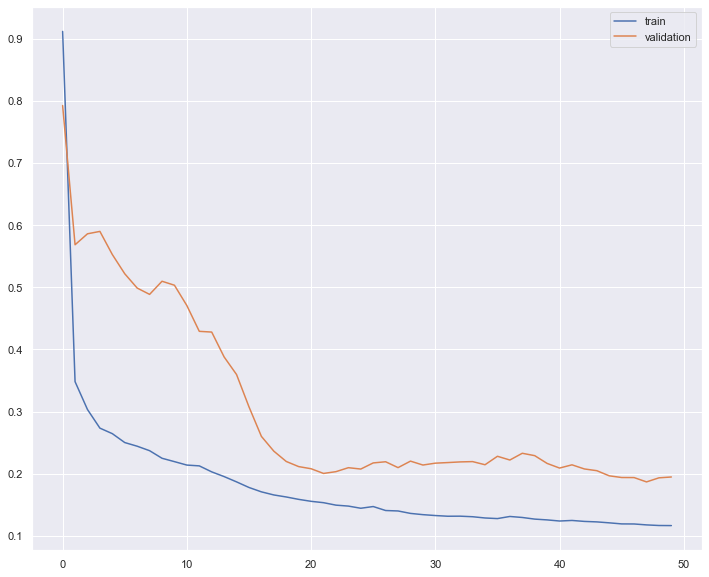

In [72]:
sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [73]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.28173146
RMSE:  0.5307838133535848
MASE:  28.994118
MAPE:  61.43055258381501 %


The above shows that retaining statefulness of LSTM cells does not lead to a performance uplift. This is suprising - what this means is that the model does not necessarily need to remember the relationships that were built between previous iterations. Let's try setting redesigning the inputs to remove the need for extended lagging periods instead. This will tell us whether prior lagging features matter, or whether it is just merely reseting the memory of cells which is helpful.

### > Remove lagging aspect

In [74]:
# get min cols
min_cols = df_shifted.columns[df_shifted.columns.str.endswith("_lag_1")].tolist()
min_cols.extend(["TAG","PM25_CONCENTRATION_THIS_HOUR"])
df_shifted_min = df_shifted[min_cols]

# create train array
train = df_shifted_min[df_shifted_min.TAG=='TRAIN']
train = train.drop('TAG',axis=1)
print(train.columns.tolist()[-1])
train_values = train.values
train_values = train_values.astype('float32')

# create validation array
validation = df_shifted_min[df_shifted_min.TAG=='VALIDATION']
validation = validation.drop('TAG',axis=1)
print(validation.columns.tolist()[-1])
validation_values = validation.values
validation_values = validation_values.astype('float32')

# create test array
test = df_shifted_min[df_shifted_min.TAG=='TEST']
test = test.drop('TAG',axis=1)
print(test.columns.tolist()[-1])
test_values = test.values
test_values = test_values.astype('float32')

# create Xs and ys
X_train = train_values[:, :-1]
y_train = train_values[:, -1]
X_validation = validation_values[:, :-1]
y_validation = validation_values[:, -1]
X_test = test_values[:, :-1]
y_test = test_values[:, -1]

print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

timestep = 1

X_train_reshaped = X_train.reshape(X_train.shape[0], timestep, 12)
X_validation_reshaped = X_validation.reshape(X_validation.shape[0], timestep, 12)
X_test_reshaped = X_test.reshape(X_test.shape[0], timestep, 12)

print(X_train_reshaped.shape,y_train.shape,X_validation_reshaped.shape,y_validation.shape,X_test_reshaped.shape,y_test.shape)

PM25_CONCENTRATION_THIS_HOUR
PM25_CONCENTRATION_THIS_HOUR
PM25_CONCENTRATION_THIS_HOUR
(33092, 12) (33092,) (4349, 12) (4349,) (4316, 12) (4316,)
(33092, 1, 12) (33092,) (4349, 1, 12) (4349,) (4316, 1, 12) (4316,)


In [75]:
# define model
try_mask = "yes" # or "yes" or no"
  
model = Sequential()

if try_mask == "yes": # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50))
    
else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 38s 1ms/sample - loss: 2.6907 - mse: 2.6907 - mae: 1.0568 - val_loss: 0.2308 - val_mse: 0.2308 - val_mae: 0.3366
Epoch 2/50
33092/33092 [==============================] - 11s 319us/sample - loss: 0.2042 - mse: 0.2042 - mae: 0.2873 - val_loss: 0.1559 - val_mse: 0.1559 - val_mae: 0.2549
Epoch 3/50
33092/33092 [==============================] - 10s 316us/sample - loss: 0.1527 - mse: 0.1527 - mae: 0.2325 - val_loss: 0.1316 - val_mse: 0.1316 - val_mae: 0.2296
Epoch 4/50
33092/33092 [==============================] - 10s 312us/sample - loss: 0.1326 - mse: 0.1326 - mae: 0.2137 - val_loss: 0.1269 - val_mse: 0.1269 - val_mae: 0.2267
Epoch 5/50
33092/33092 [==============================] - 10s 313us/sample - loss: 0.1185 - mse: 0.1185 - mae: 0.2048 - val_loss: 0.1269 - val_mse: 0.1269 - val_mae: 0.2393
Epoch 6/50
33092/33092 [==============================] - 10s 312us/sample - loss: 0.107

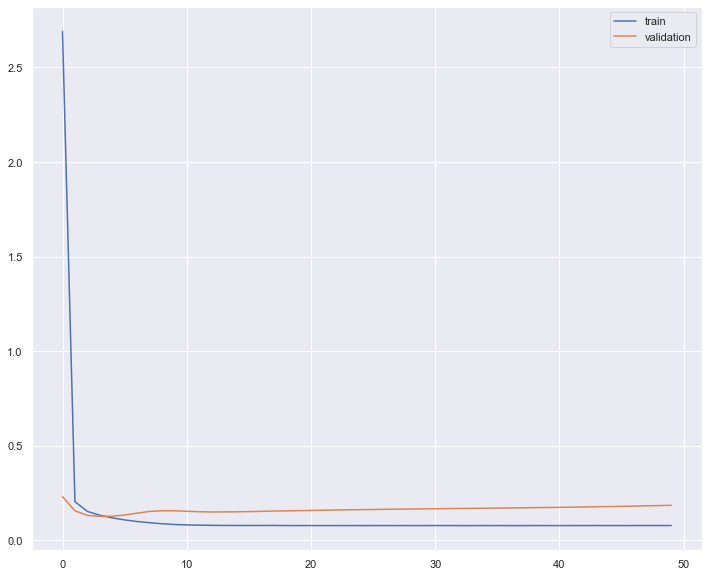

In [76]:
sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [77]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.30372146
RMSE:  0.5511092974354569
MASE:  52.281353
MAPE:  70.74693545437341 %


Clearly, having lagging timesteps is helpful. However, retaining the state of neurons is not beneficial against our validation set. Overall, our default hyperparameters seem to have the best performance. Next, we can consider adding another layer to if 

### > Add hidden layer.

https://machinelearningmastery.com/stacked-long-short-term-memory-networks/. Return_sequences needs to be set to true when stacking lstm networks. This will return one output for each input time step and provide a 3D array.

Otherwise, we will encounter 'ValueError: Input 0 of layer lstm_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 50]", https://github.com/keras-team/keras/issues/7403



In [44]:
# define model
try_mask = "yes" # or "yes" or no"
  
model = Sequential()

if try_mask == "yes": # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50,return_sequences=True,dropout=0.1))
    
else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]),return_sequences=True,dropout=0.1))
    
model.add(LSTM(50,dropout=0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 57s 2ms/sample - loss: 0.7020 - mse: 0.7020 - mae: 0.5869 - val_loss: 1.7015 - val_mse: 1.7015 - val_mae: 1.1052
Epoch 2/50
33092/33092 [==============================] - 16s 487us/sample - loss: 0.2968 - mse: 0.2968 - mae: 0.4193 - val_loss: 1.3895 - val_mse: 1.3895 - val_mae: 0.9792
Epoch 3/50
33092/33092 [==============================] - 21s 647us/sample - loss: 0.2251 - mse: 0.2251 - mae: 0.3569 - val_loss: 0.5155 - val_mse: 0.5155 - val_mae: 0.5758
Epoch 4/50
33092/33092 [==============================] - 15s 445us/sample - loss: 0.1745 - mse: 0.1745 - mae: 0.3072 - val_loss: 0.2024 - val_mse: 0.2024 - val_mae: 0.3523
Epoch 5/50
33092/33092 [==============================] - 16s 471us/sample - loss: 0.1481 - mse: 0.1481 - mae: 0.2781 - val_loss: 0.1495 - val_mse: 0.1495 - val_mae: 0.2970
Epoch 6/50
33092/33092 [==============================] - 15s 461us/sample - loss: 0.131

33092/33092 [==============================] - 15s 462us/sample - loss: 0.0804 - mse: 0.0804 - mae: 0.1936 - val_loss: 0.1152 - val_mse: 0.1152 - val_mae: 0.2744
Epoch 48/50
33092/33092 [==============================] - 14s 433us/sample - loss: 0.0793 - mse: 0.0793 - mae: 0.1923 - val_loss: 0.1214 - val_mse: 0.1214 - val_mae: 0.2848
Epoch 49/50
33092/33092 [==============================] - 15s 453us/sample - loss: 0.0801 - mse: 0.0801 - mae: 0.1924 - val_loss: 0.1450 - val_mse: 0.1450 - val_mae: 0.3205
Epoch 50/50
33092/33092 [==============================] - 15s 450us/sample - loss: 0.0795 - mse: 0.0795 - mae: 0.1923 - val_loss: 0.1320 - val_mse: 0.1320 - val_mae: 0.3013


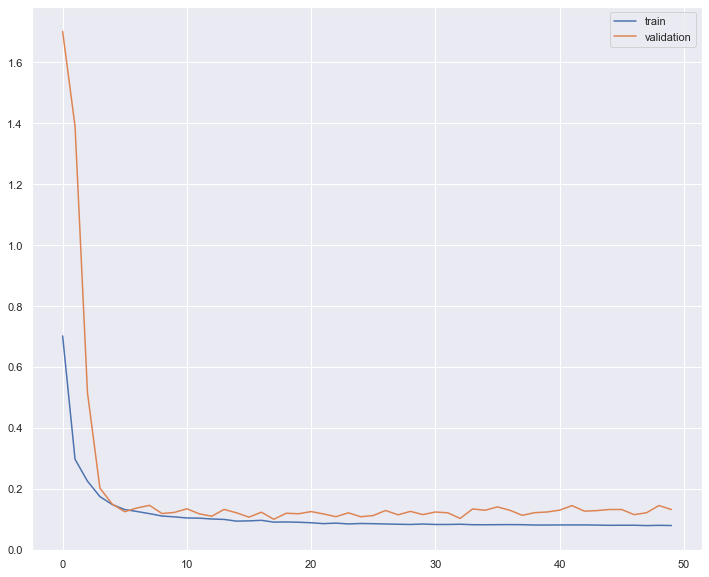

In [45]:
sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

With an added layer, we are possibly able to learn more complex relationships in our dataset, with the risk of overfitting. From the graph, we take longer to converge our validation and training losses. Also note, training time is slower.

In [46]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.11867508
RMSE:  0.344492500530827
MASE:  25.237934
MAPE:  27.01966395618913 %


Train on 33092 samples, validate on 4349 samples
Epoch 1/50
33092/33092 [==============================] - 56s 2ms/sample - loss: 1.1024 - mse: 1.1024 - mae: 0.7225 - val_loss: 1.0114 - val_mse: 1.0114 - val_mae: 0.8122
Epoch 2/50
33092/33092 [==============================] - 13s 404us/sample - loss: 0.3236 - mse: 0.3236 - mae: 0.4382 - val_loss: 0.9444 - val_mse: 0.9444 - val_mae: 0.7735
Epoch 3/50
33092/33092 [==============================] - 14s 435us/sample - loss: 0.2798 - mse: 0.2798 - mae: 0.4058 - val_loss: 0.9546 - val_mse: 0.9546 - val_mae: 0.7798
Epoch 4/50
33092/33092 [==============================] - 16s 497us/sample - loss: 0.2338 - mse: 0.2338 - mae: 0.3669 - val_loss: 0.7974 - val_mse: 0.7974 - val_mae: 0.7163
Epoch 5/50
33092/33092 [==============================] - 17s 522us/sample - loss: 0.1810 - mse: 0.1810 - mae: 0.3158 - val_loss: 0.4999 - val_mse: 0.4999 - val_mae: 0.5742
Epoch 6/50
33092/33092 [==============================] - 16s 487us/sample - loss: 0.143

Epoch 48/50
33092/33092 [==============================] - 9s 284us/sample - loss: 0.0804 - mse: 0.0804 - mae: 0.1935 - val_loss: 0.1211 - val_mse: 0.1211 - val_mae: 0.2826
Epoch 49/50
33092/33092 [==============================] - 10s 299us/sample - loss: 0.0789 - mse: 0.0789 - mae: 0.1908 - val_loss: 0.1013 - val_mse: 0.1013 - val_mae: 0.2512
Epoch 50/50
33092/33092 [==============================] - 11s 336us/sample - loss: 0.0793 - mse: 0.0793 - mae: 0.1919 - val_loss: 0.1081 - val_mse: 0.1081 - val_mae: 0.2612


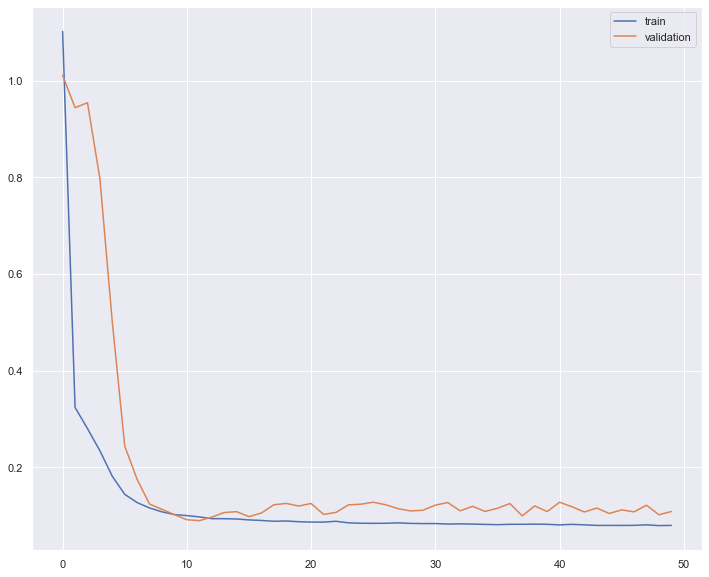

In [47]:
# define model
try_mask = "yes" # or "yes" or no"
  
model = Sequential()

if try_mask == "yes": # if we want to mask our missing values
    model.add(Masking(mask_value=-999999, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(LSTM(50,return_sequences=True,dropout=0.1))
    
else:
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]),return_sequences=True,dropout=0.1))
    
model.add(LSTM(25,dropout=0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) # https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, validation_data=(X_validation_reshaped, y_validation), verbose=1, shuffle=False)

sns.set(rc={'figure.figsize':(12,10)})
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [48]:
y_preds = model.predict(X_test_reshaped)
temp = []
for pred in y_preds:
    temp.append(pred[0])
    
y_preds = np.array(temp)
y_preds_inv = np.expm1(y_preds)
y_test_inv = np.expm1(y_test)

mse = mean_squared_error(y_test, y_preds)
rmse = sqrt(mean_squared_error(y_test, y_preds))
apes = []
aes = []

for this_y_test, this_preds in zip(y_test_inv,y_preds_inv):
    this_ae = np.abs((this_y_test - this_preds))
    this_ape = this_ae / this_y_test * 100
    aes.append(this_ae)
    apes.append(this_ape)
    
mae = np.mean(aes)
mape = np.mean(apes)

print("Test loss metrics:")
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MASE: ", mae)
print("MAPE: ", mape, "%")

Test loss metrics:
MSE:  0.09503141
RMSE:  0.30827165042491944
MASE:  21.698006
MAPE:  24.57893931718474 %


<h2> 6) Conclusion </h2>

This is a simple exploration of LSTM's for time series predictions. There is a lot more we can, in particular, a deeper dive into LSTM architectures.

For now, we conclude that the best model is a neural network with two hidden layers with some regularisation via dropout.

We save this model below.

In [49]:
# serialize model to JSON
model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("my_model.h5")
print("Saved model to disk")
 
# from keras.models import model_from_json    
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
print(model.summary())

Saved model to disk


In [50]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 10, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 50)            12600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 20,226
Trainable params: 20,226
Non-trainable params: 0
_________________________________________________________________
None
